# Test Re-test analysis

In [90]:
#Import python notebooks
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import scipy.io as sio
import os
import glob
from scipy.stats import norm
import math
# import arviz as az
# import pymc3 as pm
import pandas as pd
from datetime import datetime, timedelta
plt.rcParams.update({'font.size': 16})

## Load the data

In [119]:
#Change the directory
os.chdir('C:\\Users\\Jonathan\\Documents\\GitHub\\Split-Belt-AFC-Reliability\\Data\\TestRetest_PSI')

#Load the data
File_names = glob.glob("*.mat")

print('Files:')

Combined_data = []
for i, f in enumerate(File_names):
    Current_Subject = f[:-9]
    print(f)
    
    D = sio.loadmat(f)
    
    #Change these to 1d instead of 2
    D['AllResponses'] = D['AllResponses'][0]
    D['AllStarts'] = D['AllStarts'][0]
    D['AllStims'] = D['AllStims'][0]
    D['BinaryResponses'] = D['BinaryResponses'][0]
    D['alpha_EV'] = D['alpha_EV'][0]
    D['beta_EV'] = D['beta_EV'][0]

    #Trial Length
    Ntrials = len(D['BinaryResponses'])
    
    #Baseline difference
    D['BslDiff'] = np.ones_like(D['BinaryResponses'])*D['BslDiff'][0]
    #Subject ID and test number
    D['SID'] = [Current_Subject[:-1]]*Ntrials
    D['Test'] = [Current_Subject[-1]]*Ntrials
    
    #Start and end date time
    Test_Start = D.pop('PhaseStart')
    PhaseStart = datetime.strptime(Test_Start[0], "%d-%b-%Y %H:%M:%S")
    Test_Length = timedelta(seconds=D.pop('elapsedTime')[0][0])
    PhaseEnd = PhaseStart+Length
    D['StartTime'] = [PhaseStart]*Ntrials
    D['EndTime'] = [PhaseEnd]*Ntrials
    
    #Delete the unnecessary keys
    del D['__header__'], D['__version__'], D['__globals__']
    
    #Create dataframe 
    currentDF = pd.DataFrame.from_dict(D)
    Combined_data.append(currentDF)
DF = pd.concat(Combined_data)

Files:
PSItest_07b_data.mat


## Index Start positions and Test length

In [111]:
SIDs = pd.unique(DF.SID)
TNs = pd.unique(DF.Test)
Time = []
for i in range(len(SIDs)):
    
#     T1 = DF.Time[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[0]
#     T2 = DF.Time[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[0]
#     Time.append([T1, T2])
    
    for t in range(len(TNs)):
        
        Starts = DF.AllStarts[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
        Stims = DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
                
        TD = Starts > Stims 
        BU = Starts < Stims
        if sum(TD) == sum(BU):
            print(SIDs[i],  TNs[t], '- Start Positions Equal (Top-Down=', str(sum(TD)), '; Bottom-Up=', str(sum(BU)), ')')
        elif sum(TD) != sum(BU):
            print(SIDs[i],  TNs[t], '- Start Positions Unequal (Top-Down=', str(sum(TD)), '; Bottom-Up=', str(sum(BU)), ')')
            
# Time = np.array(Time)
# Time /= 60

# plt.figure(figsize=(3,4))
# plt.plot([np.ones(len(Time)), np.ones(len(Time))*2], [Time[:,0], Time[:,1]] ,'k-')
# plt.plot([1, 2],[np.mean(Time[:,0]), np.mean(Time[:,1])],'r--',lw=3)
# plt.xlim(0.5, 2.5)
# plt.ylim(2, 15)
# plt.xticks([1,2],['T1', 'T2'])
# plt.title('Test Time')
# plt.ylabel('Minutes')
# plt.show()

PSItest_07 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )


## Visualize each entire trial

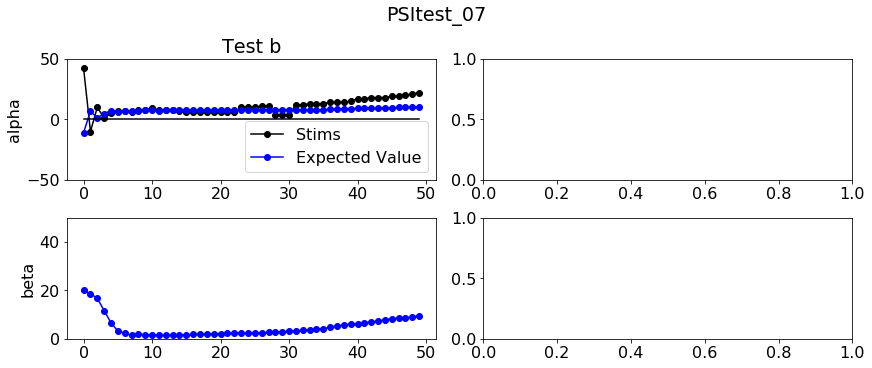

In [115]:
SIDs = pd.unique(DF.SID)
TNs = pd.unique(DF.Test)

for i in range(len(SIDs)):
    fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(12,5))
    
    for t in range(len(TNs)):
        Stims = DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
        Starts = DF.AllStarts[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
        aEV = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
        bEV = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
        
        ax[0,t].plot(Stims,'ko-',label='Stims')
        ax[0,t].plot(aEV,'bo-',label='Expected Value')
        ax[0,t].plot(np.zeros(len(Stims)),'k-')
        ax[0,t].set(ylim=(-50,50),ylabel='alpha',title='Test '+ TNs[t])
        if t == 0:
            ax[0,t].legend()
        
        ax[1,t].plot(bEV,'bo-')
        ax[1,t].set(ylim=(0,50),ylabel='beta')
    
    fig.suptitle(SIDs[i])
#     fig.show()

## Visually compare the two psychometric functions 


-3.1760091610050836
6.915976313460613


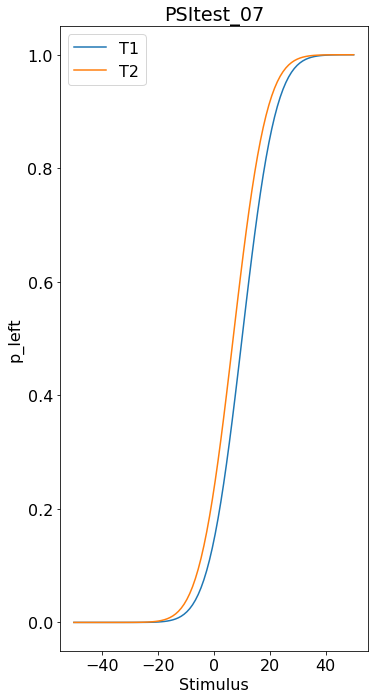

In [120]:
SIDs = pd.unique(DF.SID)
x = np.linspace(-50,50,100) #X-axis 

#Set up the figure
figrows = math.ceil(len(SIDs)/2)
plt.figure(figsize=(10,10))

#initialize for parameters
alphas = []
betas = []
for i in range(len(SIDs)):

    #Index baseline difference
    BDa = DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[0]
    BDb = DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[0]

    #index estimates for test 1 and 2
    aEV_1 = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1] + BDa
    bEV_1 = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1]

    aEV_2 = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1] + BDb
    bEV_2 = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1]

    #Store the estimates
    alphas.append([aEV_1, aEV_2])
    betas.append([bEV_1, bEV_2])
    
    #Calculate the psychometric functions
    psi_1 = norm.cdf(x,aEV_1,bEV_1)
    psi_2 = norm.cdf(x,aEV_2,bEV_2)

    plt.subplot(figrows,2,i+1)
    plt.plot(x,psi_1,label='T1')
    plt.plot(x,psi_2,label='T2')
    plt.title(SIDs[i])
    if i==0:
        plt.legend()
        plt.ylabel('p_left')
        plt.xlabel('Stimulus')
        
plt.tight_layout()
plt.show()

alphas = np.array(alphas)
betas = np.array(betas)

## Compare the parameters

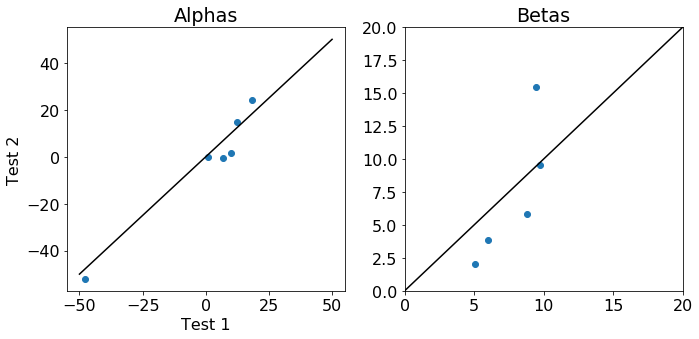

array([[ 18.41288104,  24.0272896 ],
       [  1.00252127,  -0.1999047 ],
       [ 12.33431112,  14.95540881],
       [-48.        , -52.        ],
       [  7.00088698,  -0.33066765],
       [ 10.09198547,   1.71533022]])

In [47]:
#Calculate CCC


#Plot the parameters
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(alphas[:,0],alphas[:,1],'o')
plt.plot(x,x,'k')
plt.title('Alphas')
plt.xlabel('Test 1')
plt.ylabel('Test 2')

plt.subplot(1,2,2)
plt.plot(betas[:,0],betas[:,1],'o')
plt.plot(x,x,'k')
plt.title('Betas')
plt.ylim(0, 20)
plt.xlim(0, 20)

plt.tight_layout()
plt.show()
alphas